In [5]:
!pip install opencv-python opencv-python-headless numpy PyMuPDF #preparing and uploading the provided pdf.

In [6]:
from google.colab import files
uploaded = files.upload()

Saving Checkerboard-A4-30mm-8x6.pdf to Checkerboard-A4-30mm-8x6 (1).pdf


In [9]:
import fitz  # PyMuPDF (Extracting the image from the pdf)
import numpy as np
import cv2
import io
from PIL import Image
pdf_filename = list(uploaded.keys())[0]
pdf_document = fitz.open(pdf_filename)

image_list = []

for page_number in range(len(pdf_document)):
    page = pdf_document.load_page(page_number)
    for img_index, img in enumerate(page.get_images(full=True)):
        xref = img[0]
        base_image = pdf_document.extract_image(xref)
        image_bytes = base_image["image"]
        image = Image.open(io.BytesIO(image_bytes))
        image_np = np.array(image)
        image_list.append(image_np)

# If no images were found using the above method, trying to rendering the page
if not image_list:
    for page_number in range(len(pdf_document)):
        page = pdf_document.load_page(page_number)
        pix = page.get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        image_list.append(np.array(img))

print(f"Extracted {len(image_list)} images from the PDF.")


Extracted 1 images from the PDF.


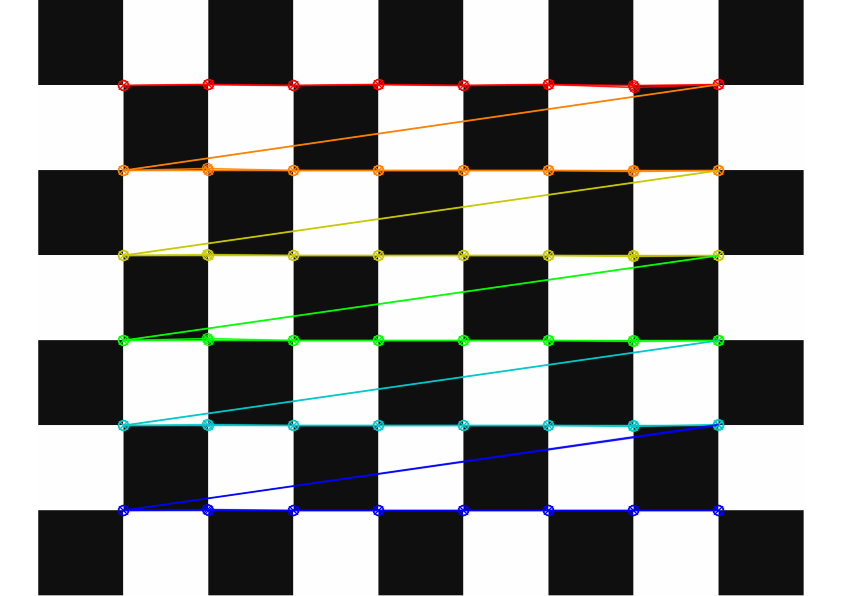

Camera matrix:
 [[2.73079190e+05 0.00000000e+00 4.20442965e+02]
 [0.00000000e+00 2.73644018e+05 2.97733577e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
 [[-1.09212343e+02 -2.68342298e-04 -1.18313533e-01  1.55983148e-02
  -5.10185019e-10]]


In [11]:
from google.colab.patches import cv2_imshow

# Termination criteria for the iterative algorithm to find the checkerboard corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Preparing object points for a 6x8 checkerboard pattern
objp = np.zeros((6*8, 3), np.float32)
objp[:, :2] = np.mgrid[0:8, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

for img in image_list:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Finding the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)

    # If found, adding object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)

        # Drawing and displaying the corners
        img = cv2.drawChessboardCorners(img, (8, 6), corners2, ret)
        cv2_imshow(img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Saving the calibration results
np.savez('camera_calibration.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)

# Printing the camera matrix and distortion coefficients
print("Camera matrix:\n", mtx)
print("Distortion coefficients:\n", dist)


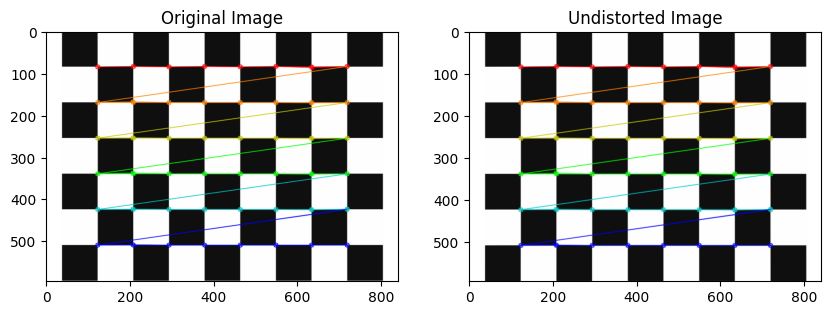

In [12]:
# Loading the saved calibration data
calibration_data = np.load('camera_calibration.npz')
mtx = calibration_data['mtx']
dist = calibration_data['dist']

# Choosing one image to undistort
img = image_list[0]
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

# Undistorting the image
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# Croping of the image based on the region of interest
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]

# Displaying the original and undistorted images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Undistorted Image')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()
